*First compiled: September 16, 2017.*

# Graph Abstraction for Deep Learning

The graph of neighborhood relations of data points in pixel space is useless if computed with a simple distance metric (euclidian, cosine, correlation-based, etc.). Deep Learning generates a feature space in which data points are positioned according to biological similarity and hence generates a distance metric that is much more valuable. Here, we demonstrate how graph abstraction is applied in this case.

[Eulenberg, Köhler, *et al.*, Nat. Commun. (2017)](https://doi.org/10.1101/081364) showed that continuous biological processes can be reconstructed using deep learning. Their results can be reproduced from https://github.com/theislab/deepflow. A video on how the deep learning based feature space organizes data according to biological similarity is here: https://youtu.be/eyWcHIiCazE. We'll use their analysis as a starting point.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import scanpy.api as sc

sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 1
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+21.g7c3f248 on 2017-10-04 23:36.


Download the features of [Eulenberg, Köhler, *et al.*, Nat. Commun. (2017)](https://doi.org/10.1101/081364) [here](http://falexwolf.de/scanpy_usage/170529_images/).

In [6]:
adata = sc.read('./data/G1SG2/stain_G1SG2_features.csv', cache=True)

reading file ./write/data/DeepFlow_data/stain/stain_G1SG2_features.h5


In [36]:
annotation = pd.read_csv('./data/G1SG2/stain_G1SG2.lst', delimiter='\t', header=None)

In [7]:
annotation.head()

,0,1,2
0,2,0.584232,../images/G2/40531_bright_field.jpg
1,12,0.555460,../images/G2/9425_bright_field.jpg
2,23,0.833180,../images/G2/28599_bright_field.jpg
3,40,0.628845,../images/G2/33523_bright_field.jpg
4,50,0.522287,../images/G2/16060_bright_field.jpg


In [43]:
adata.smp['cell_cycle_stages'] = annotation[2].str.lstrip('../images').str.split('/').str[0]
adata.smp['DNA_content'] = annotation[1]
# just a random cell (the first) within G1
adata.add['iroot'] = np.arange(adata.n_smps)[adata.smp['cell_cycle_stages'] == 'G1'][0]
adata.add['highlights'] = [adata.add['iroot']]

In [11]:
sc.tl.tsne(adata)
sc.write('deepflow', adata)

computing tSNE
    preprocess using PCA with 50 PCs
--> avoid this by setting n_pcs = 0
    using 50 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:08.475) and added
    "X_tsne", tSNE coordinates (adata.smp)
writing ./write/deepflow.h5


reading ./write/deepflow.h5


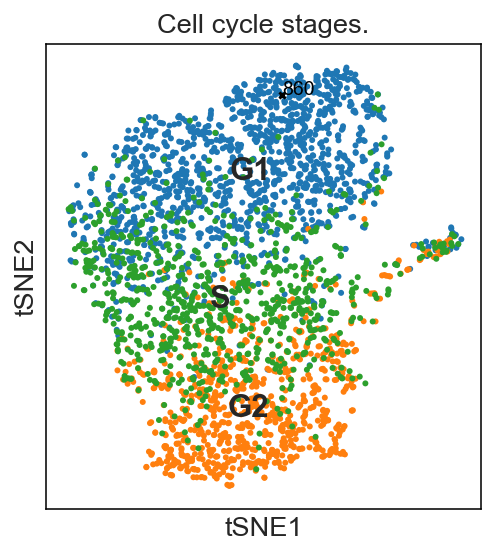

In [3]:
adata = sc.read('deepflow')
axs = sc.pl.tsne(adata, legend_loc='on data', 
                 title='Cell cycle stages.',
                 legend_fontsize=16, legend_fontweight='bold',
                 color='cell_cycle_stages')

In [45]:
sc.tl.aga(adata, resolution=0.5, recompute_louvain=True)
sc.write('deepflow', adata)

reading ./write/deepflow.h5
saving figure to file ./figures/aga.png


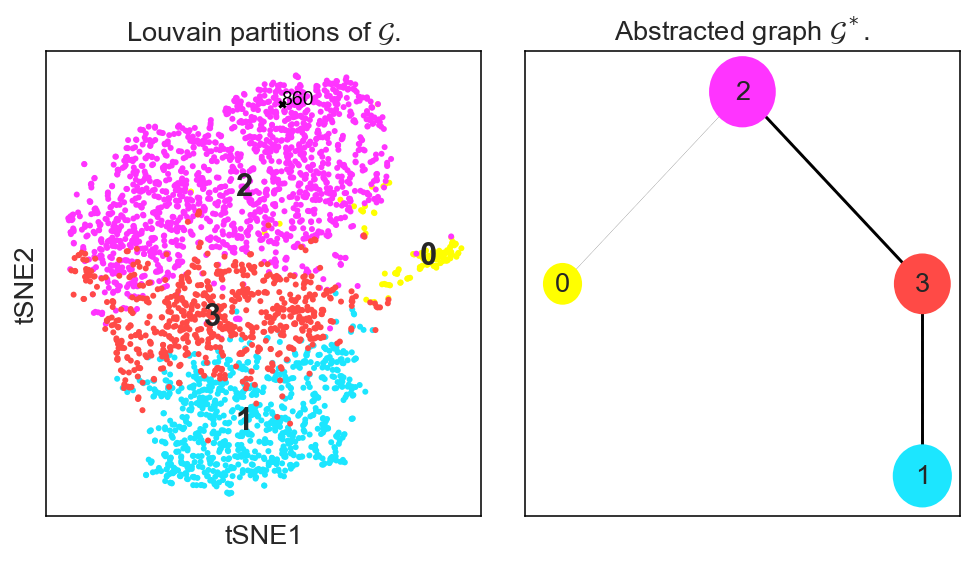

In [20]:
adata = sc.read('deepflow')
axs = sc.pl.aga(adata, palette=sc.pl.palettes.godsnot_64, color='aga_groups', groups_graph='aga_groups', 
                node_size_power=0.2, node_size_scale=2,
          legend_fontsize=16, legend_fontweight='bold',
          title='Louvain partitions of $\mathcal{G}$.',
          title_graph='Abstracted graph $\mathcal{G}^*$.',
          root=2, layout='rt', save=True)

In [18]:
asso_groups, asso_matrix = sc.utils.compute_association_matrix_of_groups(adata, 'aga_groups', 'cell_cycle_stages')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.vega_20_scanpy, asso_matrix)

saving figure to file ./figures/aga_cell_cycle_stages.png


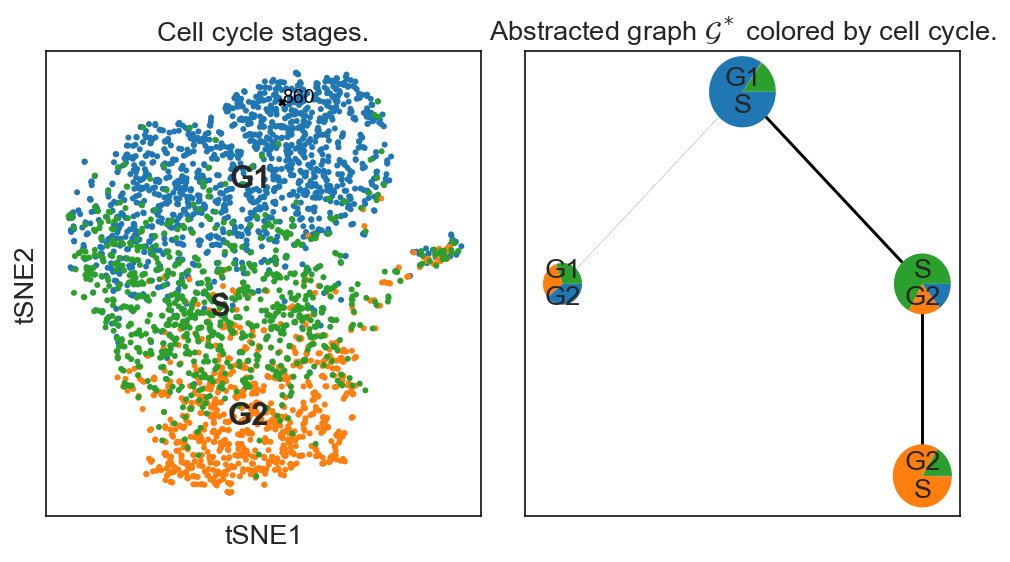

In [21]:
axs = sc.pl.aga(adata, color='cell_cycle_stages', node_size_power=0.2, node_size_scale=2,
                title_graph='Abstracted graph $\mathcal{G}^*$ colored by cell cycle.',
                legend_fontsize=16, legend_fontweight='bold', 
                color_graph=asso_colors,
                groups_graph=asso_groups, title='Cell cycle stages.', 
                root=2, layout='rt', frameon=True, show=True, save='_cell_cycle_stages')

Study the progression along the single-cell graph.

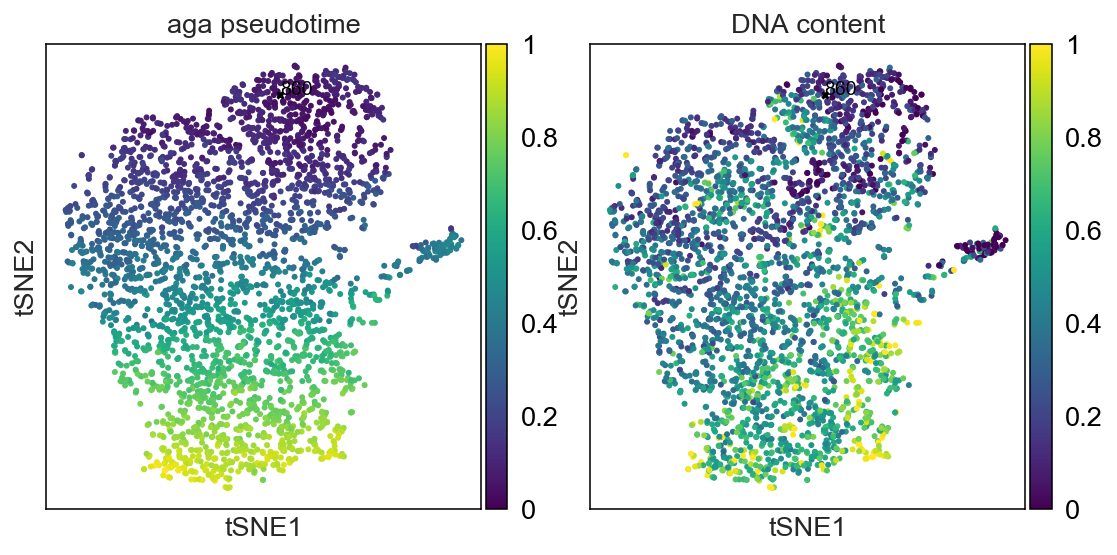

In [49]:
adata = sc.read('deepflow')
axs = sc.pl.tsne(adata, legend_loc='on data', legend_fontsize=16, legend_fontweight='bold',
                 color=['aga_pseudotime', 'DNA_content'], color_map='viridis')

The absracted graph tells us to consider a path along nodes 2, 3 and 1.

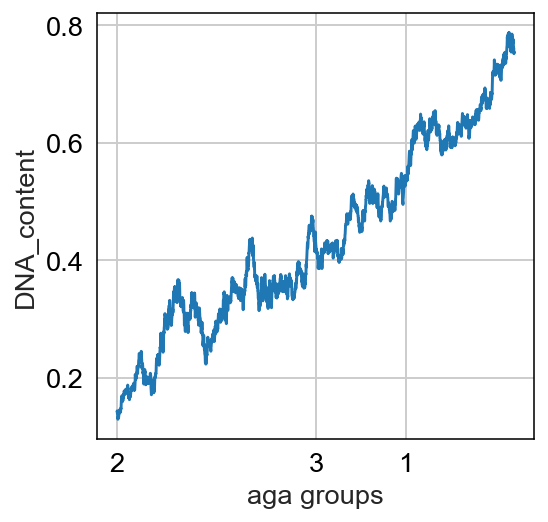

In [3]:
adata = sc.read('deepflow')
ax = sc.pl.aga_path(adata, nodes=[2, 3, 1], keys=['DNA_content'], n_avg=50,
                    as_heatmap=False, show_nodes_twin=False, save=True, show=True)

If we ignore the abstracted graph and consider a path that includes the cluster of damaged cells, we obtain a non-smoooth increase.

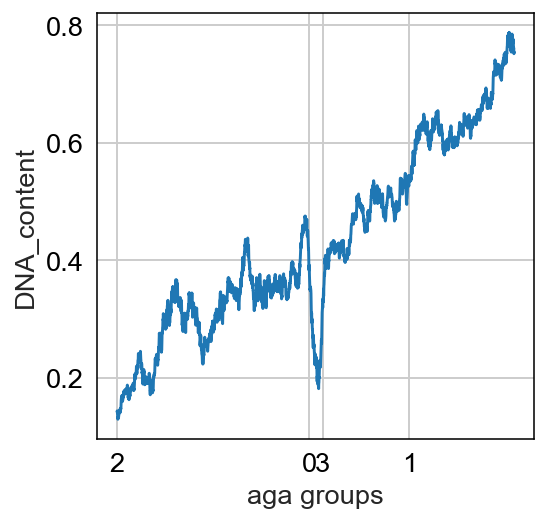

In [4]:
ax = sc.pl.aga_path(adata, nodes=[2, 0, 3, 1], keys=['DNA_content'], n_avg=50,
                    as_heatmap=False, show_nodes_twin=False, save='_kink', show=True)

# Supplemental Note: Analyzing all 7 cell cycle phases

Let us now analyze all 7 cell cycle phases.

In [3]:
adata = sc.read('./data/all_phases/features/acts.csv', cache=True)
annotation = pd.read_csv('./data/all_phases/features/va.lst', delimiter='\t', header=None)

reading file ./data/all_phases/features/acts.csv
    did not find column names in file
    read data into list of lists (0:00:08.371)
    constructed array from list of list (0:00:00.007)
    did not find row names in file
... writing an h5 cache file to speedup reading next time
writing ./write/data/all_phases/features/acts.h5


In [6]:
print(annotation.head())

    0  1                                           2
0   0  0   ../images/Anaphase/30890_bright_field.jpg
1   4  0   ../images/Anaphase/41639_bright_field.jpg
2  10  1  ../images/Telophase/13708_bright_field.jpg
3  12  1  ../images/Telophase/33963_bright_field.jpg
4  24  1  ../images/Telophase/21332_bright_field.jpg


In [7]:
adata.smp['cell_cycle_stages'] = annotation[2].str.lstrip('../images').str.split('/').str[0]

In [8]:
sc.tl.tsne(adata)
sc.write('deepflow_all', adata)

computing tSNE
    preprocess using PCA with 50 PCs
--> avoid this by setting n_pcs = 0
    using 50 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:10.803) and added
    "X_tsne", tSNE coordinates (adata.smp)
writing ./write/deepflow_all.h5


In [11]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (8, 4)

reading file ./write/deepflow_all.h5


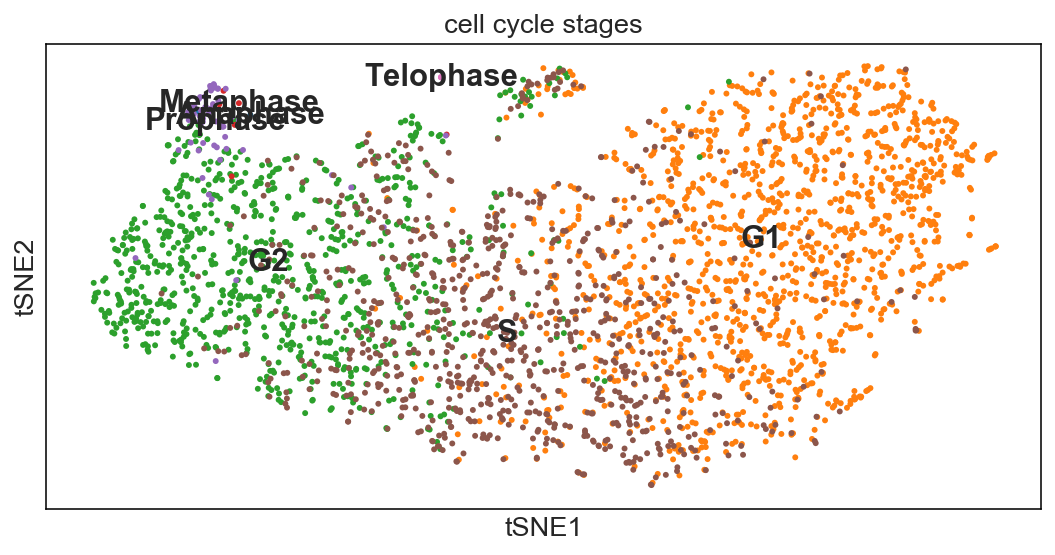

In [12]:
adata = sc.read('deepflow_all')
axs = sc.pl.tsne(adata, legend_loc='on data', legend_fontsize=16, legend_fontweight='bold',
                 color='cell_cycle_stages')

The cluster of damaged cells is detected, but the mitotic phases not.

reading file ./write/deepflow_all.h5
... you are using a very low resolution for saving figures, adjusting to dpi=300
... saving figure to file ./figures/aga.png


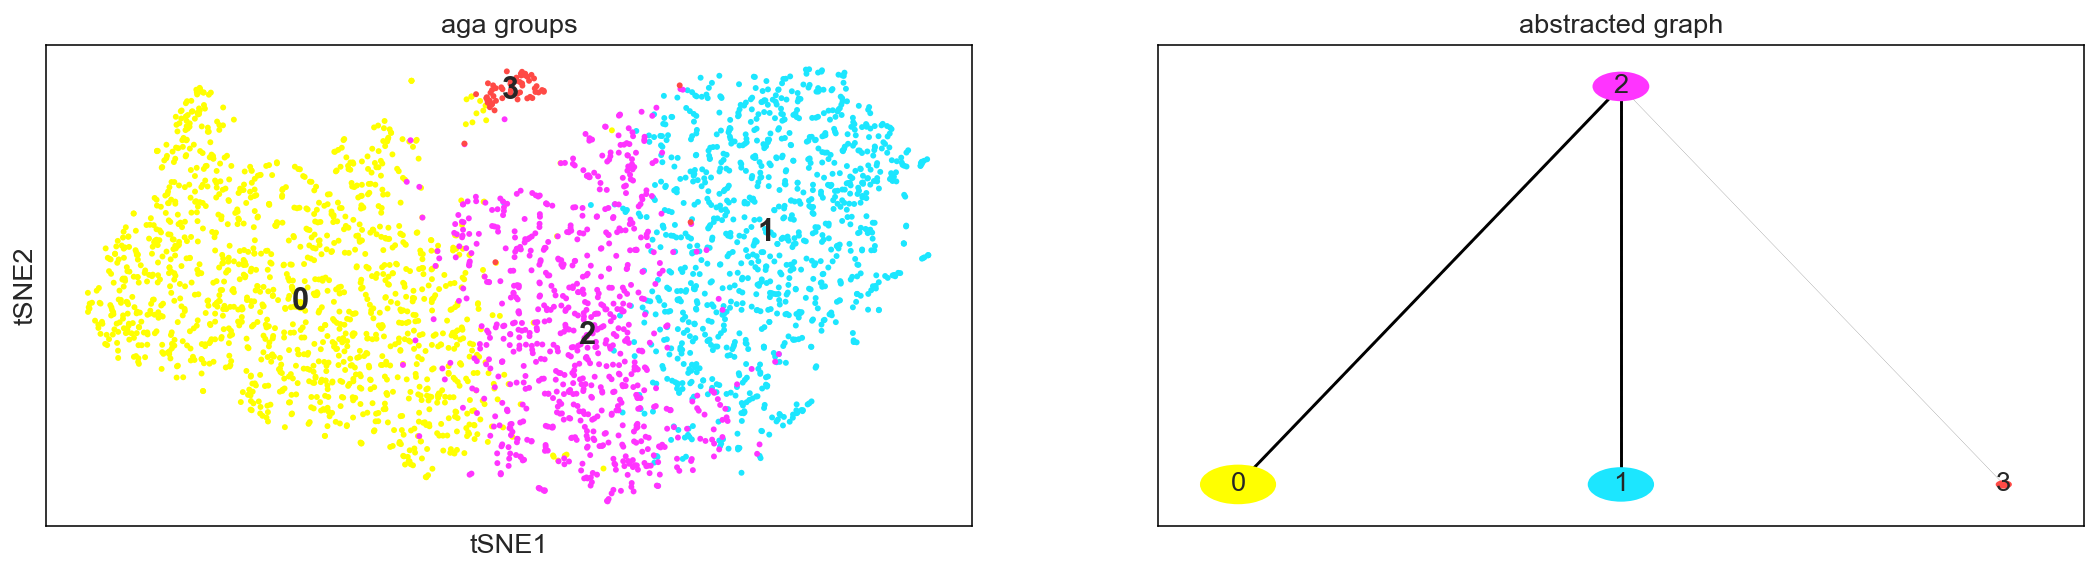

In [14]:
sc.tl.aga(adata, resolution=0.5, recompute_louvain=True)
sc.pl.aga(adata, palette=sc.pl.palettes.godsnot_64, color='aga_groups', groups_graph='aga_groups', 
          legend_fontsize=16, legend_fontweight='bold',
          title_graph='abstracted graph',
          root=2, layout='rt', frameon=True, save=True, show=True)

Increasing the resolution still yields a consistent graph, but the mitotic phases are still not detected.

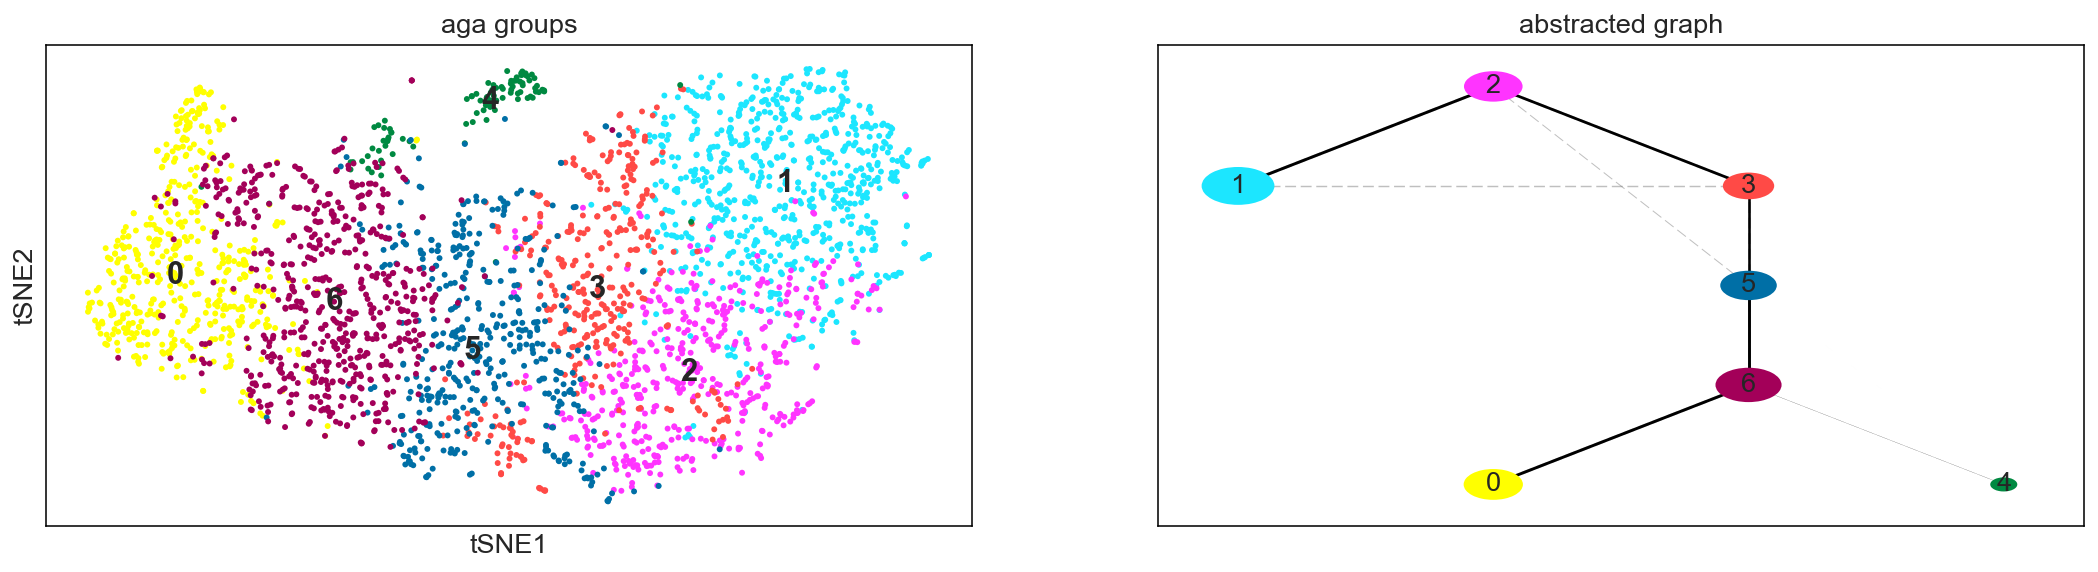

In [19]:
sc.tl.aga(adata, resolution=1.0, recompute_louvain=True)
sc.pl.aga(adata, palette=sc.pl.palettes.godsnot_64, color='aga_groups', groups_graph='aga_groups', 
          legend_fontsize=16, legend_fontweight='bold',
          title_graph='abstracted graph',
          root=2, layout='rt', frameon=True, save=True, show=True)

In [23]:
sc.pl.reset_rcParams()